# Linear Classification / Logistic Regression

### Task Description

You have a dataset of handwritten digits containing only two numbers, 1 and 5.

You will find the training and the test data set under `dataset_numbers_train.npy` and `dataset_numbers_test.npy`.

Your task is to find a good linear classifier to classify these images.

If $y_i = 0$ then the $i$-th image represents a one, otherwise $y_i = 1$ represents a five.

- What is your best test accuracy?

You have to implement the following:

1. Logistic Loss

1. Logistic Regression using scikit-learn with the provided inverse of regularization strength, no intercept, and 10000 maximum number of iterations.

The template provided in this notebook already has k-Fold Cross-Validation and a few other functions.

In [2]:
# Importing libraries

import numpy as np
from numpy.typing import ArrayLike
from typing import Optional
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import KFold
from typing import Generator

In [3]:
def load_data(name: str) -> tuple[ArrayLike, ArrayLike]:
    """Loads data from provided .npy files and returns the x and y values.
    Args:
        name (str): The file name of the .npy file to load.
    Returns:
        tuple[ArrayLike, ArrayLike]: The x and y values of the data. x has shape (n,d) and y has shape (n,).
    """
    data = np.load(name)
    x = data[:, :-1]
    y = data[:, -1]
    return x, y

In [4]:
def plot_numbers(numb: ArrayLike, tag: ArrayLike, rng: Generator = None) -> None:
    """Plots 8 random images of the digits 0 and 5 from the dataset.
    Args:
        numb (ArrayLike): The dataset containing the images of the digits.
        tag (ArrayLike): The labels for the images in the dataset.
        rng (Generator, optional): Random number generator. Defaults to None.
    """
    if rng is None:
        rng = np.random.default_rng(seed=66)
    ones = numb[tag == 0]
    fives = numb[tag == 1]

    (fig, axs) = plt.subplots(nrows=2, ncols=4)

    indx = rng.integers(len(ones), size=4)
    for ax, i in zip(axs[0], indx):
        ax.imshow(ones[i].reshape(28, 28), cmap="gray", vmin=0, vmax=1)

    indx = rng.integers(len(fives), size=4)
    for ax, i in zip(axs[1], indx):
        ax.imshow(fives[i].reshape(28, 28), cmap="gray", vmin=0, vmax=1)

    plt.show()

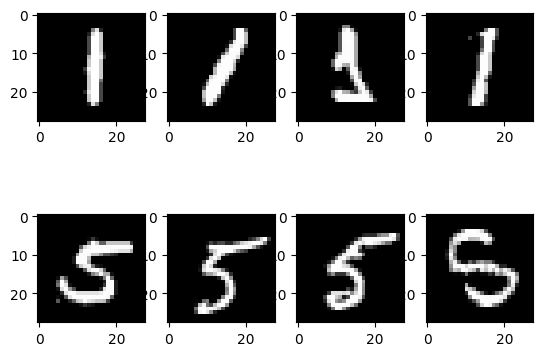

In [5]:
# Visualize your data

x_train, y_train = load_data("dataset_numbers_train.npy")
plot_numbers(x_train, y_train)

In [ ]:
def log_loss(X: ArrayLike, y: ArrayLike, w: ArrayLike, b: float) -> float:
    """Computes the log loss.
    Args:
        X (ArrayLike): The input data of shape (n,d).
        y (ArrayLike): The labels of shape (n,).
        w (ArrayLike): The weights of shape (d,).
        b (float): The intercept.
    Returns:
        float: The log loss.
    """

    n = X.shape[0]
    epsilon = 1e-6

    s = 1 / (1 + np.exp(-X @ w - b))
    s = np.clip(s, epsilon, 1 - epsilon)  # Avoid log(0)
    loss = -np.mean(y * np.log(s) + (1 - y) * np.log(1 - s))

    return loss

In [ ]:
from sklearn import linear_model

def logistic_regression(
    X: ArrayLike, y: ArrayLike, lam: float = 0
) -> linear_model.LogisticRegression:
    """Fit an instance of Logistic Regression.
    Args:
        X (ArrayLike): The input data of shape (n,d).
        y (ArrayLike): The output data of shape (n,).
    Returns:
        LogisticRegression: The fitted Logistic Regression model.
    """

    # Logistic Regression using scikit-learn with the provided inverse of regularization strength, no intercept, and 10000 maximum number of iterations.

 # manage regularization strength consistently when lambda is zero
    model = linear_model.LogisticRegression(
        C=lam if lam > 0 else 1e10,
        fit_intercept=False,
        max_iter=10000
    )
    model.fit(X, y)
    
    return model

In [10]:
def kfold(x: ArrayLike, y: ArrayLike, lam: float, k: int = 10) -> tuple[float, float]:
    """Performs k-fold cross-validation to evaluate the model's performance.
    Args:
        x (ArrayLike): The input data of shape (n, d).
        y (ArrayLike): The output data of shape (n,).
        lam (float): The regularization parameter.
        k (int, optional): The number of folds. Defaults to 10.
    Returns:
        tuple[float, float]: Average train and validation scores ¡¡PER DATA POINT!!.
    """

    # Ensure k is not greater than the number of samples
    assert k <= x.shape[0], "k cannot be greater than the number of samples."
    assert k > 1, "k must be greater than 1."

    train_acc_value = 0.0
    val_acc_value = 0.0
    for train_index, valid_index in KFold(n_splits=k, shuffle=True).split(x, y):
        x_train = x[train_index]
        y_train = y[train_index]

        x_valid = x[valid_index]
        y_valid = y[valid_index]

        model = logistic_regression(x_train, y_train, lam=lam)

        train_acc_value += model.score(x_train, y_train)
        val_acc_value += model.score(x_valid, y_valid)

    avg_train_loss = train_acc_value / k
    avg_val_loss = val_acc_value / k

    return avg_train_loss, avg_val_loss

In [11]:
def get_score_curve_data(
    x: ArrayLike, y: ArrayLike, lambdas: ArrayLike
) -> tuple[int, ArrayLike, ArrayLike]:
    """Computes the best lambda and returns its index and train and validation scores for lambdas.
    Args:
        x (ArrayLike): The input data of shape (n, d).
        y (ArrayLike): The output data of shape (n,).
        lambdas (ArrayLike): The range of lambda values to evaluate.
    Returns:
        int: The best lambda index based on the validation score.
        ArrayLike: The training scores for each lambda value.
        ArrayLike: The validation scores for each lambda value.
    """

    train_scores = []
    val_scores = []
    for lam in lambdas:
        train_score, val_score = kfold(x, y, lam, k=10)
        train_scores.append(train_score)
        val_scores.append(val_score)

    return np.argmax(val_scores).item(), train_scores, val_scores

In [12]:
def plot_score_curve(
    lambdas: ArrayLike,
    train_scores: ArrayLike,
    val_scores: Optional[ArrayLike] = None,
    score_name: str = "Accuracy",
) -> None:
    """Plots the score curve.
    Args:
        lambdas (ArrayLike): The regularization values.
        train_scores (ArrayLike): The training scores.
        val_scores (ArrayLike, optional): The validation scores. Defaults to None.
    """

    plt.plot(
        lambdas,
        train_scores,
        color="#D81B60",
        linewidth=2.5,
        label=f"Train {score_name}",
    )
    if val_scores is not None:
        plt.plot(
            lambdas,
            val_scores,
            color="#1E88E5",
            linewidth=2.5,
            label=f"Valid {score_name}",
        )
    plt.legend()
    plt.xscale("log")
    plt.xlabel("Lambda")
    plt.ylabel(f"{score_name}")
    plt.grid()
    plt.show()

In [ ]:
lambdas = np.logspace(-4, 0, num=30, base=10)
best_lam_idx, train_scores, val_scores = get_score_curve_data(x_train, y_train, lambdas)
print(f"Best inverse lambda (C): {lambdas[best_lam_idx]}")
print(f"Train accuracy: {train_scores[best_lam_idx]:.8f}")
print(f"Validation accuracy: {val_scores[best_lam_idx]:.8f}")

plot_score_curve(
    lambdas,
    train_scores,
    val_scores,
)

model = logistic_regression(x_train, y_train, lam=lambdas[best_lam_idx])
print(f"Train accuracy: {model.score(x_train, y_train)}")

x_test, y_test = load_data("dataset_numbers_test.npy")
print(f"Test accuracy: {model.score(x_test, y_test)}")